# Clinical trial design optimization 

## Loading dependencies

In [9]:
# Cookbook specifics imports
import jinko_helpers as jinko
from jinko_stats import sample_size_continuous_outcome, sample_size_binary_outcome
import math
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import textwrap

## Defining general parameters

In [ ]:
"""
Sample size parameters
"""

alpha = 0.05
beta = 0.1
dropout = 0  # drop-out ratio

"""
Number of times the required sample size should be included in the best responder population. 
The best responder population must have at least sample_size patients in order to compute bootstraps.
The minimal size of the population of best responders will be sample_size * num_sample_size_repeats
"""
num_sample_size_repeats = 10

"""
Boostrapping parameters
"""
## Number of bootstraps for gross efficacy dispersion estimation
num_bootstraps = 50
## Seed for all random processes
cookbook_seed = 2025

""" 
Efficacy measure
"""


# continuous example
def efficacy(outcome_control, outcome_treated):
    return outcome_control - outcome_treated


# # binary example
# def efficacy(outcome_control, outcome_treated):
#     return outcome_treated - outcome_control


"""
Objective function
"""
# weight of gross efficacy
efficacy_wt = 1
# weight of standard deviation of gross efficacy
efficacy_sd_wt = 1


def objective_function(
    efficacy,
    efficacy_sd,
):
    return (efficacy * efficacy_wt - efficacy_sd * efficacy_sd_wt) / (
        efficacy_wt + efficacy_sd_wt
    )


class Descriptor:
    def __init__(self, identifier, arm=None):
        self.identifier = identifier
        self.arm = arm
        self.column_id = (
            self.identifier if self.arm is None else f"{self.identifier}_{self.arm}"
        )
        self.arm_id = "crossArms" if self.arm is None else self.arm
        self.lower_bound_id = f"{self.column_id}_lower_bound"
        self.width_id = f"{self.column_id}_width"

    def format_descriptor(self):
        return self.identifier

    def set_lower_bound(self, lower_bound):
        self.lower_bound = lower_bound

    def set_upper_bound(self, upper_bound):
        self.upper_bound = upper_bound


# Jinko trial short ID, URL pattern is "https://jinko.ai/{trial_sid}"
trial_sid = "tr-4bHo-BMO3"
# # Outcome ID
outcome_name = "SCORAD_30_days"
outcome_type = "continuous"
# control and treated arm IDs
control_arm_id = "Emollient"
treated_arm_id = "Emollient_and_Moderate_TCS"

all_descriptors = [
    Descriptor("SCORAD_baseline", arm="Emollient"),
    Descriptor("log_Type1Cy_baseline", arm="Emollient"),
    Descriptor("log_Type2Cy_baseline", arm="Emollient"),
    Descriptor("log_IL17_baseline", arm="Emollient"),
]
num_descriptors = len(all_descriptors)

# initialize connection to Jinko
jinko.initialize()

# Convert short id to core item id
trial_core_item_id = jinko.get_core_item_id(trial_sid, 1)

# Choose a specific revision or label. By default we return the last version
revision = None
label = "cookbook"
response = jinko.get_project_item(sid=trial_sid, label=label)
trial_core_item_id, trial_snapshot_id = (
    response["coreId"]["id"],
    response["coreId"]["snapshotId"],
)

# # Uncomment the following to get the latest completed version instead
# response = jinko.get_latest_trial_with_status(shortId=trial_sid, statuses=["completed", "stopped"])
# trial_core_item_id, trial_snapshot_id = response["coreItemId"], response["snapshotId"]

## Loading trial results from Jinko

In [11]:
def load_trial_data(outcome_name):
    print(f"Load trial data")
    scalars_df = jinko.get_trial_scalars_as_dataframe(
        trial_core_item_id,
        trial_snapshot_id,
        scalar_ids=[d.identifier for d in all_descriptors] + [outcome_name],
    )

    conditions = [
        (scalars_df["armId"] == d.arm_id) & (scalars_df["scalarId"] == d.identifier)
        for d in all_descriptors
    ]
    unpivoted_descriptors_df = scalars_df[np.logical_or.reduce(conditions)]
    for d in all_descriptors:
        row_filter = (unpivoted_descriptors_df["armId"] == d.arm_id) & (
            unpivoted_descriptors_df["scalarId"] == d.identifier
        )
        unpivoted_descriptors_df.loc[row_filter] = unpivoted_descriptors_df[
            row_filter
        ].assign(scalarId=d.column_id)
    descriptors_df = unpivoted_descriptors_df.pivot(
        index="patientId", columns="scalarId", values="value"
    )
    outcome_control = (
        scalars_df[
            (scalars_df["armId"] == control_arm_id)
            & (scalars_df["scalarId"] == outcome_name)
        ]
        .assign(scalarId="outcome_control")
        .pivot(index="patientId", columns="scalarId", values="value")
    )
    outcome_treated = (
        scalars_df[
            (scalars_df["armId"] == treated_arm_id)
            & (scalars_df["scalarId"] == outcome_name)
        ]
        .assign(scalarId="outcome_treated")
        .pivot(index="patientId", columns="scalarId", values="value")
    )
    main_df = pd.merge(
        left=pd.merge(
            left=descriptors_df, right=outcome_control, how="left", on="patientId"
        ),
        right=outcome_treated,
        how="left",
        on="patientId",
    ).dropna()

    mean_control = main_df["outcome_control"].mean()
    mean_treated = main_df["outcome_treated"].mean()
    initial_net_efficacy = efficacy(mean_control, mean_treated)

    std_control = main_df["outcome_control"].std()

    if outcome_type == "continuous":
        print(
            f"This trial has an efficacy of {initial_net_efficacy:.3g} (standard deviation of outcome in control group = {std_control:.2g})"
        )
        trial_sample_size = math.ceil(
            sample_size_continuous_outcome(
                alpha, beta, initial_net_efficacy, std_control, dropout
            )
        )
    elif outcome_type == "binary":
        print(
            f"This trial has a proportion of responders of {mean_control:.3g} in control group and {mean_treated:.2g} in treated group"
        )
        trial_sample_size = math.ceil(
            sample_size_binary_outcome(alpha, beta, mean_control, mean_treated, dropout)
        )
    print(
        f"With beta = {beta}, this means a sample size of {trial_sample_size} patients per group"
    )

    if len(main_df) < trial_sample_size * num_sample_size_repeats:
        print(
            f"\n⛔ Not enough patients in the initial trial: num_patients_per_arm < trial_sample_size * num_sample_size_repeats ⛔"
        )
        remedy = """
        Consider one of the following: 
            1. decrease num_sample_size_repeats
            2. run a new trial with a larger vpop
            3. increase alpha or beta
        """
        print(remedy)

    return main_df, trial_sample_size

In [12]:
def compute_score_proxy(main_df, trial_sample_size):
    neigh_regressor = KNeighborsRegressor(
        n_neighbors=trial_sample_size * num_sample_size_repeats,
        weights="uniform",
        metric="chebyshev",
        n_jobs=4,
    )
    X_unscaled = main_df[[d.column_id for d in all_descriptors]].to_numpy()
    feature_scaler = StandardScaler().fit(X_unscaled)
    X = feature_scaler.transform(X_unscaled)
    score_proxy = main_df.copy(deep=True)
    print(f"Fit nearest neighbor regressors for both arms")
    for arm in ["control", "treated"]:
        neigh_regressor.fit(
            X,
            score_proxy[f"outcome_{arm}"].to_numpy(),
        )
        score_proxy[f"mu_outcome_{arm}"] = neigh_regressor.predict(X)

        neigh_regressor.fit(
            X,
            (score_proxy[f"outcome_{arm}"].to_numpy()) ** 2,
        )
        score_proxy[f"mu_outcome_{arm}_squared"] = neigh_regressor.predict(X)
        score_proxy[f"var_outcome_{arm}"] = (
            score_proxy[f"mu_outcome_{arm}_squared"]
            - score_proxy[f"mu_outcome_{arm}"] ** 2
        )
    # score proxy where the mean of gross efficacy is approximated using the mean of absolute benefit
    # and the variance of gross efficacy is approximated as 'var(control) + var(treated) / sample_size'
    score_proxy["score_proxy"] = objective_function(
        efficacy(
            score_proxy[f"mu_outcome_control"], score_proxy[f"mu_outcome_treated"]
        ),
        np.sqrt(
            score_proxy[f"var_outcome_control"] + score_proxy[f"var_outcome_treated"]
        )
        / np.sqrt(trial_sample_size),
    )

    score_proxy = score_proxy.sort_values(by="score_proxy")
    return score_proxy, neigh_regressor


def plot_score_proxy(score_proxy):
    features_wrapped = [
        "<br>".join(textwrap.wrap(t.identifier, width=30)) for t in all_descriptors
    ]
    min_score, max_score = (
        score_proxy["score_proxy"].min(),
        score_proxy["score_proxy"].max(),
    )
    # print(f"Min score proxy = {min_score:.3g}, max score proxy = {max_score:.3g}")
    fig = make_subplots(
        num_descriptors,
        num_descriptors,
        shared_xaxes=True,
        shared_yaxes=False,
        horizontal_spacing=0.03,
        vertical_spacing=0.01,
        column_titles=features_wrapped,
        row_titles=features_wrapped,
    )

    for i in range(num_descriptors):  # iterating over rows
        for j in range(num_descriptors):  # iterating over columns
            if i == j:  # do not plot anything on the diagonal
                x = score_proxy[all_descriptors[i].column_id]
                nx = 10
                xs = np.linspace(x.min(), x.max(), nx + 1)
                y = []
                for k in range(nx):
                    eff_k = score_proxy[
                        (score_proxy[all_descriptors[i].column_id] >= xs[k])
                        & (score_proxy[all_descriptors[i].column_id] < xs[k + 1])
                    ]["score_proxy"]
                    y.append(eff_k.mean())
                fig.add_trace(
                    go.Scatter(x=xs[:-1] + 0.5 * (xs[1] - xs[0]), y=y, mode="lines"),
                    row=i + 1,
                    col=j + 1,
                )
            else:
                fig.add_trace(
                    go.Scattergl(
                        x=score_proxy[all_descriptors[j].column_id],
                        y=score_proxy[all_descriptors[i].column_id],
                        mode="markers",
                        marker=dict(
                            size=5,
                            color=score_proxy["score_proxy"],
                            opacity=(score_proxy["score_proxy"] - min_score)
                            / (max_score - min_score),
                            coloraxis="coloraxis1",
                        ),
                        hoverinfo="none",
                    ),
                    row=i + 1,
                    col=j + 1,
                )
    fig.update_annotations(font_size=15)
    fig.update_coloraxes(
        colorbar_title="score",
        cmin=min_score,
        cmax=max_score,
        colorscale="rainbow",
        colorbar_thickness=15,
        colorbar_title_side="right",
    )
    fig.update_layout(
        font=dict(size=15),
        showlegend=False,
        width=1000,
        height=900,
        template="plotly_white",
    )
    fig.show(renderer="jpeg")

In [13]:
class EligibilityCriteria:
    def __init__(self, descriptors: list[Descriptor]):
        self.descriptors = descriptors
        self.criteria_ids = [
            descriptor.lower_bound_id for descriptor in descriptors
        ] + [descriptor.width_id for descriptor in descriptors]
        self.bounds = {}
        for descriptor in descriptors:
            (d_min, d_max) = (descriptor.lower_bound, descriptor.upper_bound)
            self.bounds[descriptor.lower_bound_id] = (
                d_min,
                d_max - 0.1 * (d_max - d_min),
            )
            self.bounds[descriptor.width_id] = (0.1 * (d_max - d_min), d_max - d_min)

    def column_ids(self):
        return [descriptor.column_id for descriptor in self.descriptors]

    def criteria_from_vector(self, vec: list[float]) -> dict:
        return {criterion_id: x for (criterion_id, x) in zip(self.criteria_ids, vec)}

    def criteria_to_vector(self, criteria: dict) -> list[float]:
        vec = np.zeros((len(self.criteria_ids),))
        for i, criteria_id in enumerate(self.criteria_ids):
            vec[i] = criteria[criteria_id]
        return vec

    def filter_conditions(self, dataframe, criteria):
        conditions = [
            (dataframe[descriptor.column_id] >= criteria[descriptor.lower_bound_id])
            & (
                dataframe[descriptor.column_id]
                <= criteria[descriptor.lower_bound_id] + criteria[descriptor.width_id]
            )
            for descriptor in self.descriptors
        ]
        return np.logical_and.reduce(conditions)

    def format_criteria(self, criteria):
        s = ""
        for descriptor in self.descriptors:
            s += f"\n {criteria[descriptor.lower_bound_id]:.3g} <= {descriptor.format_descriptor()} <= {criteria[descriptor.lower_bound_id] + criteria[descriptor.width_id]:.3g}"
        return s

    # returns the mean and standard deviation of the gross efficacy using the absolute benefit
    def gross_efficacy_using_absolute_benefit(self, dataframe, criteria, sample_size):
        filtered_df = dataframe[self.filter_conditions(dataframe, criteria)]
        if len(filtered_df) < sample_size * num_sample_size_repeats:
            return (None, None)
        control_filtered = filtered_df["outcome_control"]
        treated_filtered = filtered_df["outcome_treated"]
        mean_efficacy = efficacy(control_filtered.mean(), treated_filtered.mean())
        var_efficacy = (control_filtered.var() + treated_filtered.var()) / sample_size

        return (mean_efficacy, np.sqrt(var_efficacy))

    def score_vector(self, dataframe, sample_size, x):
        criteria = self.criteria_from_vector(x)
        (mean_ge, sd_ge) = self.gross_efficacy_using_absolute_benefit(
            dataframe, criteria, sample_size
        )
        if mean_ge is not None and sd_ge is not None:
            return objective_function(mean_ge, sd_ge)
        else:
            return np.nan

    # returns the mean and standard deviation of the gross efficacy using bootstrapping
    def gross_efficacy_using_bootstrap(
        self,
        dataframe,
        criteria,
        sample_size,
        seed=cookbook_seed,
        n_boot=num_bootstraps,
    ):
        # A reproducible random generator whose seed depends on the top-level cookbook seed AND the criteria
        seeds = [seed, abs(hash(frozenset(criteria.items())))]
        filtered_df = dataframe[self.filter_conditions(dataframe, criteria)]
        if len(filtered_df) < sample_size * num_sample_size_repeats:
            return (None, None)
        else:
            return self.bootstrapped_efficacy(filtered_df, sample_size, seeds, n_boot)

    def bootstrapped_efficacy(
        self,
        dataframe,
        sample_size,
        seeds,
        n_boot=num_bootstraps,
    ):
        control_filtered = dataframe["outcome_control"]
        treated_filtered = dataframe["outcome_treated"]
        rng = np.random.default_rng(seeds)
        bootstrap_gross_efficacies = []
        all_indices = np.arange(len(control_filtered))
        for _ in range(n_boot):
            # pick 2 * sample_size indices at random from the full dataset
            shuffled_indices = rng.choice(
                all_indices, size=2 * sample_size, replace=False
            )
            # first sample_size indices for the control sub-group
            ctrl_mean = control_filtered.iloc[shuffled_indices[:sample_size]].mean()
            # next sample_size indices for the treated sub-group
            trtd_mean = treated_filtered.iloc[
                shuffled_indices[sample_size : 2 * sample_size]
            ].mean()
            bootstrap_gross_efficacies.append(efficacy(ctrl_mean, trtd_mean))

        return np.mean(bootstrap_gross_efficacies), np.std(
            bootstrap_gross_efficacies, ddof=1
        )

    def net_efficacy(self, dataframe, criteria):
        filtered_df = dataframe[self.filter_conditions(dataframe, criteria)]
        net_efficacy_series = efficacy(
            filtered_df["outcome_control"], filtered_df["outcome_treated"]
        )
        mean_efficacy, std_efficacy = (
            net_efficacy_series.mean(),
            net_efficacy_series.std(),
        )
        return (mean_efficacy, std_efficacy)

    def group_size(self, dataframe, criteria):
        filtered_df = dataframe[self.filter_conditions(dataframe, criteria)]
        return len(filtered_df)

    def report(self, dataframe, criteria, sample_size, n_boot):
        (mean_ge, sd_ge) = self.gross_efficacy_using_absolute_benefit(
            dataframe, criteria, sample_size=sample_size
        )
        print(f"\nMean of gross efficacy using absolute benefit = {mean_ge:.3g}")
        print(
            f"Standard deviation of gross efficacy using absolute benefit = {sd_ge:.2g}"
        )
        score_ab = objective_function(mean_ge, sd_ge)
        print(f"Score using absolute benefit = {score_ab:.3g}")

        mean_ge, sd_ge = self.gross_efficacy_using_bootstrap(
            dataframe, criteria, sample_size=sample_size, n_boot=n_boot
        )
        print(f"\nMean of gross efficacy (with {n_boot} bootstraps) = {mean_ge:.3g}")
        print(
            f"Standard deviation of gross efficacy (with {n_boot} bootstraps) = {sd_ge:.2g}"
        )
        score_bootstrap = objective_function(mean_ge, sd_ge)
        print(f"Score using bootstrap = {score_bootstrap:.3g}")

## Eligibility criteria optimization using score proxy

In [14]:
def optimize_eligibility_criteria(
    main_df, trial_sample_size, score_proxy, neigh_regressor
):
    for descriptor in all_descriptors:
        descriptor.set_lower_bound(main_df[descriptor.column_id].min())
        descriptor.set_upper_bound(main_df[descriptor.column_id].max())
    ec = EligibilityCriteria(descriptors=all_descriptors)

    imax = score_proxy["score_proxy"].argmax()
    print(
        f"Best score before MC fine-tuning = {score_proxy.iloc[imax]["score_proxy"]:.3g}"
    )
    x0_unscaled = score_proxy.iloc[imax][ec.column_ids()].to_numpy()

    X_unscaled = score_proxy[ec.column_ids()].to_numpy()
    feature_scaler = StandardScaler().fit(X_unscaled)
    X = feature_scaler.transform(X_unscaled)
    neigh_regressor.fit(X, score_proxy["outcome_control"].to_numpy())

    x0_scaled = feature_scaler.transform(np.reshape(x0_unscaled, (1, x0_unscaled.size)))
    _distances, indices = neigh_regressor.kneighbors(
        x0_scaled, n_neighbors=trial_sample_size * num_sample_size_repeats
    )

    score_proxy_criteria = {}
    for i, descriptor in enumerate(ec.descriptors):
        min_f, max_f = np.amin(X_unscaled[indices[0, :], i]), np.amax(
            X_unscaled[indices[0, :], i]
        )
        score_proxy_criteria[descriptor.lower_bound_id] = min_f
        score_proxy_criteria[descriptor.width_id] = max_f - min_f

    # ec.report(main_df, score_proxy_criteria, sample_size=trial_sample_size, n_boot=100)
    rng = np.random.default_rng([cookbook_seed])
    num_mc = 10000
    exploration_scale = 0.01

    x0 = ec.criteria_to_vector(score_proxy_criteria)
    dim = len(ec.criteria_ids)
    X_mc = rng.normal(
        loc=x0, scale=np.absolute(x0 * exploration_scale), size=(num_mc, dim)
    )
    y = np.array([ec.score_vector(main_df, trial_sample_size, x) for x in X_mc])
    mc_i_max = np.nanargmax(y)
    print(
        f"MC fine-tuning, number of admissible points = {np.count_nonzero(~np.isnan(y))} / {X_mc.shape[0]}"
    )
    if y[mc_i_max] > score_proxy.iloc[imax]["score_proxy"]:
        best_vector = X_mc[mc_i_max]
        best_criteria = ec.criteria_from_vector(best_vector)
        print(f"Best score after MC fine-tuning = {y[mc_i_max]:.3g}")
    else:
        best_criteria = score_proxy_criteria
    return best_criteria, ec

## Potential gains

Load trial data
This trial has an efficacy of 8.55 (standard deviation of outcome in control group = 25)
With beta = 0.1, this means a sample size of 184 patients per group
Fit nearest neighbor regressors for both arms


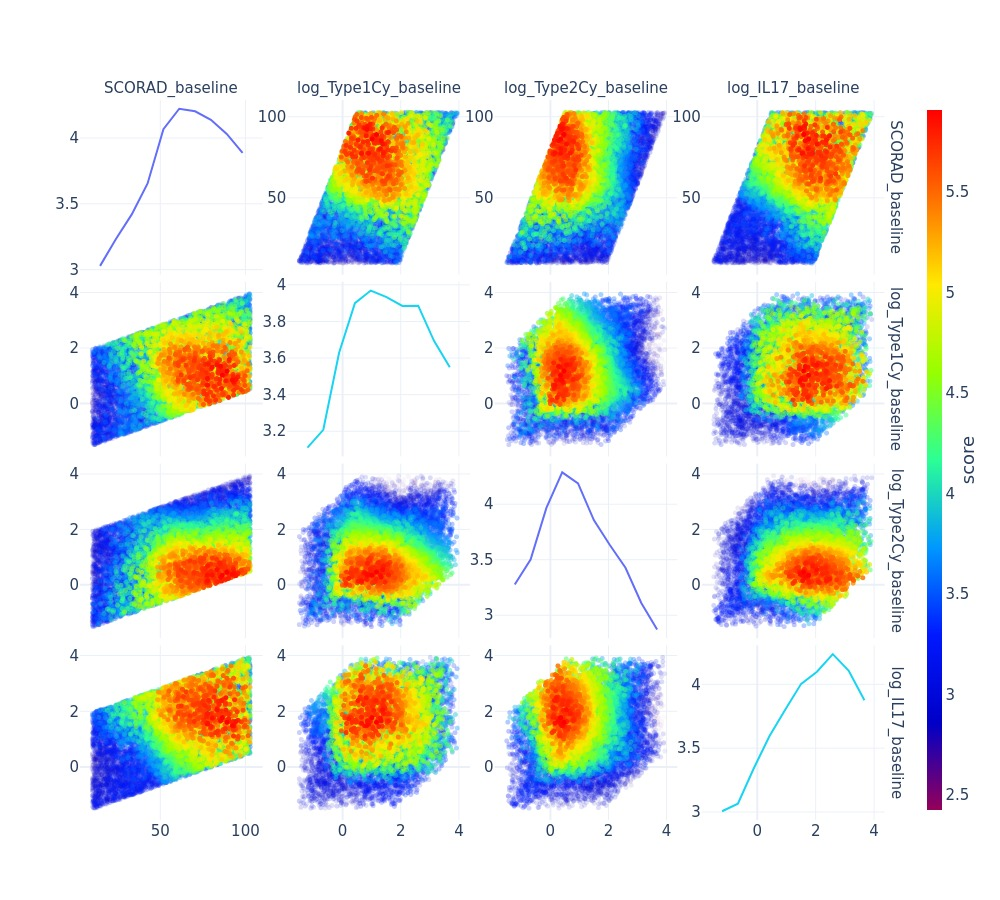

Best score before MC fine-tuning = 5.91
MC fine-tuning, number of admissible points = 4531 / 10000
Best score after MC fine-tuning = 5.99

Efficacy in initial population = 8.55
Required sample size in initial population = 184 per arm
Number of unique best responding patients: 1842
Efficacy in population of best responders = 13.8 (+62%)
Required sample size in population of best responders = 30 per arm (-84%)
    


In [ ]:
main_df, trial_sample_size = load_trial_data(outcome_name)
mean_control = main_df["outcome_control"].mean()
mean_treated = main_df["outcome_treated"].mean()
initial_net_efficacy = efficacy(mean_control, mean_treated)
if initial_net_efficacy < 0 or trial_sample_size * num_sample_size_repeats > len(
    main_df
):
    raise Exception(
        f"Initial net efficacy is negative or required sample size too large"
    )

score_proxy, neigh_regressor = compute_score_proxy(main_df, trial_sample_size)
plot_score_proxy(score_proxy)
best_eligibility_criteria, ec = optimize_eligibility_criteria(
    main_df, trial_sample_size, score_proxy, neigh_regressor
)

n_boot = 50
mean_gross_efficacy, sd_gross_efficacy = ec.bootstrapped_efficacy(
    main_df, sample_size=trial_sample_size, seeds=[0], n_boot=n_boot
)


num_responding = ec.group_size(main_df, best_eligibility_criteria)
initial_mean_gross_efficacy, initial_sd_gross_efficacy = ec.bootstrapped_efficacy(
    main_df, sample_size=trial_sample_size, seeds=[cookbook_seed], n_boot=500
)
best_mean_gross_efficacy, best_sd_gross_efficacy = ec.gross_efficacy_using_bootstrap(
    main_df, best_eligibility_criteria, sample_size=trial_sample_size, n_boot=500
)
filtered_df = main_df[ec.filter_conditions(main_df, best_eligibility_criteria)]
control_filtered = filtered_df["outcome_control"]
treated_filtered = filtered_df["outcome_treated"]
(best_responders_net_efficacy, _) = ec.net_efficacy(main_df, best_eligibility_criteria)

if outcome_type == "continuous":
    best_sample_size = math.ceil(
        sample_size_continuous_outcome(
            alpha, beta, best_responders_net_efficacy, control_filtered.std()
        )
    )
    mean_gross_efficacy, sd_gross_efficacy = ec.gross_efficacy_using_bootstrap(
        main_df, best_eligibility_criteria, sample_size=best_sample_size, n_boot=n_boot
    )
    report = f"""
Efficacy in initial population = {initial_net_efficacy:.3g}
Required sample size in initial population = {trial_sample_size} per arm
Number of unique best responding patients: {num_responding}
Efficacy in population of best responders = {best_responders_net_efficacy:.3g} (+{(best_responders_net_efficacy - initial_net_efficacy)/initial_net_efficacy:.0%})
Required sample size in population of best responders = {best_sample_size} per arm (-{(trial_sample_size - best_sample_size)/trial_sample_size:.0%})
    """
elif outcome_type == "binary":
    best_sample_size = math.ceil(
        sample_size_binary_outcome(
            alpha, beta, control_filtered.mean(), treated_filtered.mean(), dropout
        )
    )
    report = f"""
Proportion of responders in initial population (control group) = {mean_control:.0%}
Proportion of responders in initial population (treated group) = {mean_treated:.0%}
Number of unique best responding patients: {num_responding}/{len(main_df)}
Proportion of responders in best responding population (treated): {treated_filtered.mean():.0%} (+{(treated_filtered.mean() - mean_treated)/mean_treated:.0%})
Required sample size in population of best responders = {best_sample_size} per arm
  --> gain in required sample size = {trial_sample_size - best_sample_size} (-{(trial_sample_size - best_sample_size)/trial_sample_size:.0%})
    """

print(report)

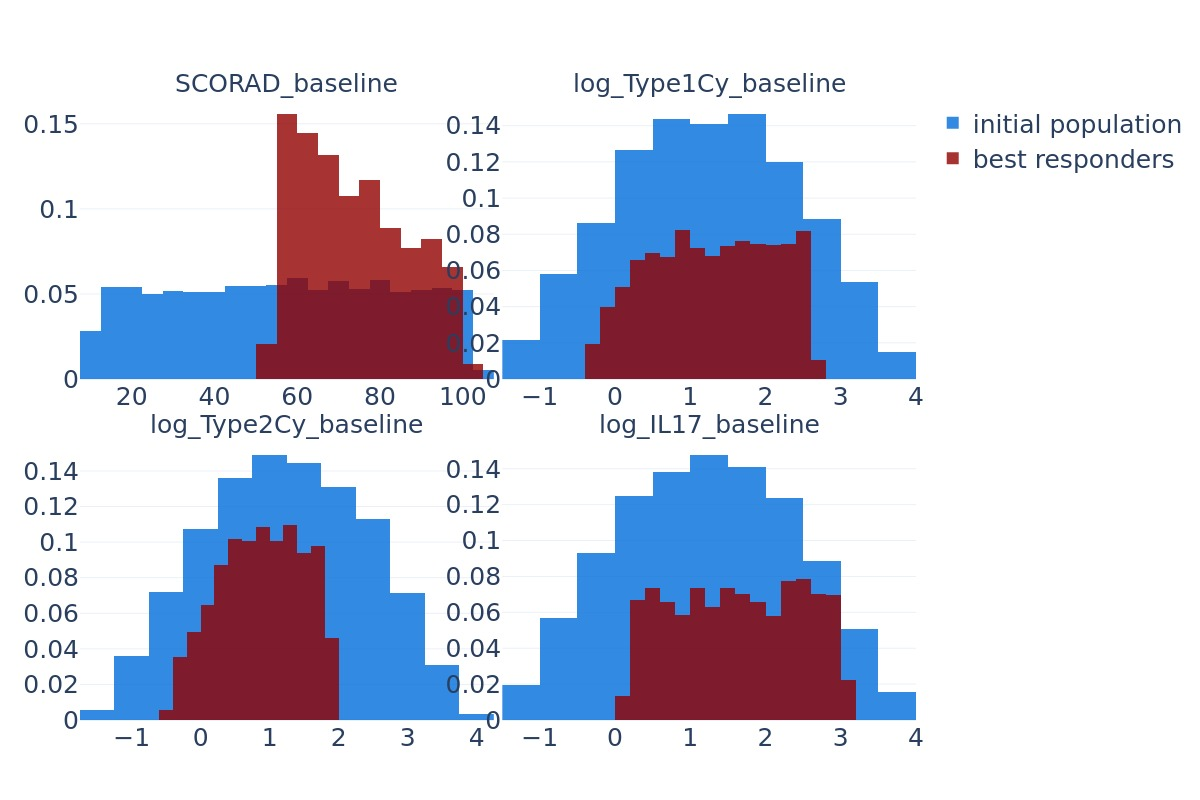

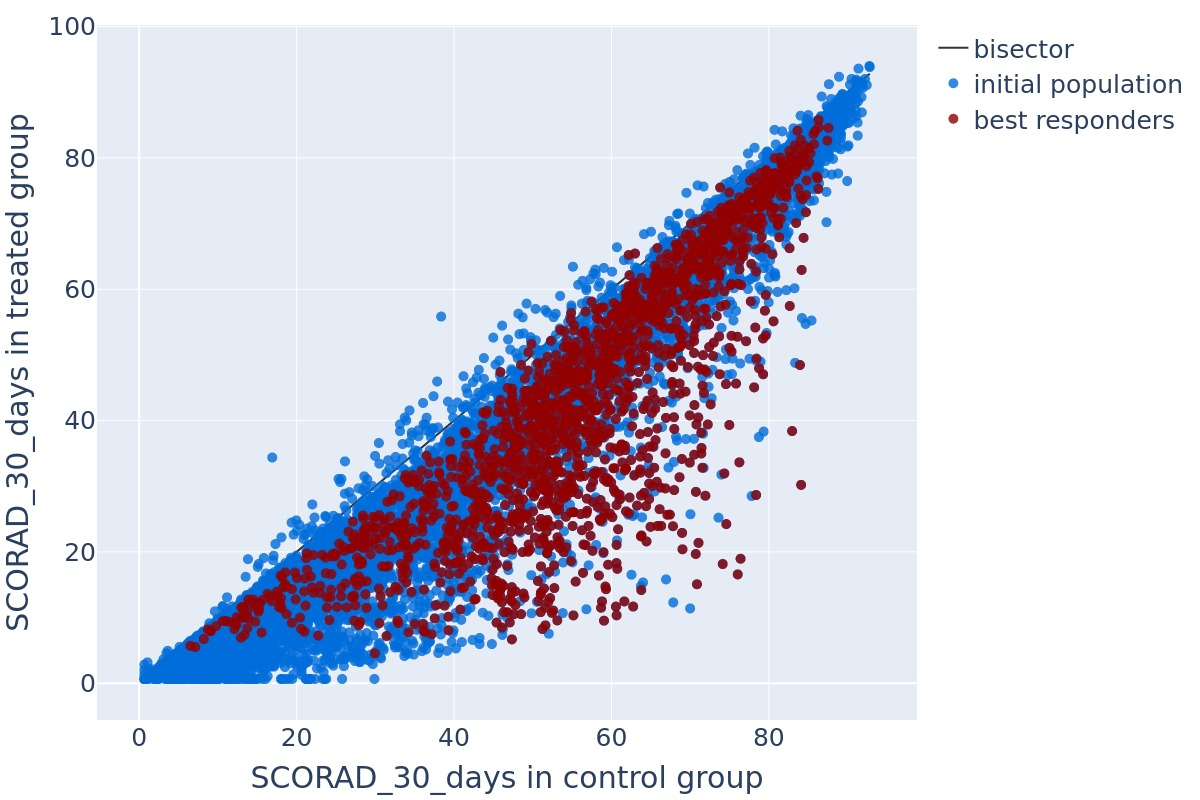

Number of patients in harmful sector of the plane (initial population): 275/10000 (3%)
Number of patients in harmful sector of the plane (best responders): 12/1842 (1%)


In [ ]:
# Histogram plots


def feature_histogram(fig, name, i, j, x, marker_color):
    fig.add_trace(
        go.Histogram(
            name=name,
            x=x,
            histnorm="probability",
            nbinsx=num_histogram_bins,
            marker_color=marker_color,
            showlegend=show_legend,
        ),
        row=i + 1,
        col=j + 1,
    )


colnames = [f.format_descriptor() for f in all_descriptors]
dimension = len(colnames)
# colnames_wrapped = ["<br>".join(textwrap.wrap(t, width=30)) for t in colnames]
colnames_wrapped = ["<br>".join(textwrap.wrap(t, width=30)) for t in colnames]
num_rows, num_cols = 2, 2
if num_rows * num_cols < dimension:
    raise Exception(
        f"Not enough rows and columns ({num_rows * num_cols = }) to plot {dimension} parameters"
    )
num_histogram_bins = 21

fig = make_subplots(
    rows=num_rows,
    cols=num_cols,
    horizontal_spacing=0.01,
    vertical_spacing=0.1,
    subplot_titles=colnames_wrapped,
)
show_legend = True
for i in range(num_rows):
    for j in range(num_cols):
        k = num_cols * i + j
        if k >= dimension:
            continue
        else:
            feature = all_descriptors[k]
            feature_histogram(
                fig, "initial population", i, j, main_df[feature.column_id], "#006ddb"
            )
            feature_histogram(
                fig,
                "best responders",
                i,
                j,
                main_df.loc[ec.filter_conditions(main_df, best_eligibility_criteria)][
                    feature.column_id
                ],
                "#920000",
            )
            show_legend = False
fig.update_annotations(font_size=25)
fig.update_traces(opacity=0.8)
figure_width = 1200
figure_height = 800
fig.update_layout(
    font=dict(size=25),
    showlegend=True,
    barmode="overlay",
    width=figure_width,
    height=figure_height,
    template="plotly_white",
)
fig.show(renderer="jpeg")

# Effect model plot
if outcome_type == "continuous":
    fig = go.Figure()
    outcome = main_df["outcome_control"]
    bisector = np.array([outcome.min(), outcome.max()])
    fig.add_trace(
        go.Scatter(
            x=bisector, y=bisector, mode="lines", line_color="black", name="bisector"
        )
    )
    fig.add_trace(
        go.Scattergl(
            x=main_df["outcome_control"],
            y=main_df["outcome_treated"],
            mode="markers",
            marker=dict(
                color="#006ddb",
                size=10,
            ),
            name="initial population",
            hoverinfo="none",
        )
    )
    responders = main_df[ec.filter_conditions(main_df, best_eligibility_criteria)]
    fig.add_trace(
        go.Scattergl(
            x=responders["outcome_control"],
            y=responders["outcome_treated"],
            mode="markers",
            marker=dict(color="#920000", size=10),
            name="best responders",
            hoverinfo="none",
        )
    )
    fig.update_xaxes(title_text=f"{outcome_name} in control group")
    fig.update_yaxes(title_text=f"{outcome_name} in treated group")
    fig.update_annotations(font_size=25)
    fig.update_traces(opacity=0.8)
    fig.update_layout(
        font=dict(size=25),
        showlegend=True,
        width=1200,
        height=800,
        margin=dict(l=50, r=20, t=20, b=20),
    )
    fig.show(renderer="jpeg")
    num_in_harmful_sector = (
        main_df["outcome_control"] < main_df["outcome_treated"]
    ).sum()
    print(
        f"Number of patients in harmful sector of the plane (initial population): {num_in_harmful_sector}/{len(main_df)} ({num_in_harmful_sector/len(main_df):.0%})"
    )

    num_responders = len(responders)
    num_in_harmful_sector = (
        responders["outcome_control"] < responders["outcome_treated"]
    ).sum()
    print(
        f"Number of patients in harmful sector of the plane (best responders): {num_in_harmful_sector}/{num_responders} ({num_in_harmful_sector/num_responders:.0%})"
    )